In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
import random
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, LSTM, RepeatVector, TimeDistributed
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans

In [3]:
#setting
weather = pd.read_csv("weather.csv")
kval = 10
itertot = 40
sigma = 1.2
itergd = 300

weather.head()

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


In [4]:
def transforminput(param, center):
	newinput = np.zeros((len(param), len(center))).astype('float32')
	for i in xrange(len(param)):
		for j in xrange(len(center)):
			newinput[i,j] = np.exp(-(np.sum((param[i] - center[j])**2.0)**0.5) / sigma**2.0)
	return newinput

def generatemodel(numparam):
	model = Sequential()
	model.add(Dense(1, input_dim=numparam, activation='sigmoid'))
#	model.add(Dense(10, activation='sigmoid'))
#	model.add(Dense(1, activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

In [5]:
# Attribute selection:
weather = weather[["temp_min", "temp_max", "precipitation", "wind", "weather"]]
weather.head()

,temp_min,temp_max,precipitation,wind,weather
0,5.0,12.8,0.0,4.7,drizzle
1,2.8,10.6,10.9,4.5,rain
2,7.2,11.7,0.8,2.3,rain
3,5.6,12.2,20.3,4.7,rain
4,2.8,8.9,1.3,6.1,rain


In [6]:
# One-Hot encoding:
# "One hot encoding is a process by which categorical variables are converted into a form that could be provided to ML algorithms to do a better job in prediction."

weather_one_hot = pd.get_dummies(weather['weather'])
weather = weather.drop('weather', axis=1)
weather = weather.join(weather_one_hot)
weather.sample(3)

,temp_min,temp_max,precipitation,wind,drizzle,fog,rain,snow,sun
885,10.0,19.4,0.0,2.6,0,0,0,0,1
149,7.8,16.1,0.0,1.8,0,0,0,0,1
1095,-2.7,3.3,0.0,3.0,0,0,0,0,1


In [7]:
# Sauce: https://www.geeksforgeeks.org/data-normalization-with-pandas/

# Copying the dataset for a backup, just in case:
weatherCopy = weather.copy()

# Normalizing our data using min-max feature scaling:
for column in weatherCopy.columns:
	# if(column != 'weather' and column != 'date'):
	weatherCopy[column] = (weatherCopy[column] - weatherCopy[column].min()) / (weatherCopy[column].max() - weatherCopy[column].min())


In [8]:
# Reordering of columns in order to get our target placed as the last column:
weatherCopy = weatherCopy[["precipitation", "temp_min", "wind", "drizzle", "fog", "rain", "snow", "sun", "temp_max"]]
weatherCopy.sample(3)

,precipitation,temp_min,wind,drizzle,fog,rain,snow,sun,temp_max
853,0.595707,0.629921,0.329670,0.0,0.0,1.0,0.0,0.0,0.446237
128,0.000000,0.649606,0.285714,0.0,0.0,0.0,0.0,1.0,0.534946
193,0.000000,0.803150,0.252747,1.0,0.0,0.0,0.0,0.0,0.731183


In [9]:
# Splitting the data into input and output columns:
x, y = weatherCopy.values[:, :-1], weatherCopy.values[:, -1]

# Ensure all values are floatinf types:
# x = x.astype('float32')

# Encode strings to integer:
# y = LabelEncoder().fit_transform(y)

# Split into training and testing datasets:
x_train_full, x_test, y_train_full, y_test = train_test_split(x, y, test_size=.33)

x_train, x_validation, y_train, y_validation = train_test_split(x_train_full, y_train_full)

# Determine the number of features:
n_features = x_train.shape[1]

# Show results:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
print('Number of features:', n_features)

(733, 8) (483, 8) (733,) (483,)
Number of features: 8


In [10]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_validation = scaler.fit_transform(x_validation)
x_test = scaler.fit_transform(x_test)

In [11]:
#Determine centers of the neurons using KMeans.

K_cent= 8
km= KMeans(n_clusters= K_cent, max_iter= 100)
km.fit(x_train)
cent= km.cluster_centers_

In [12]:
#Determine the value of sigma

max=0 
for i in range(K_cent):
	for j in range(K_cent):
		d= np.linalg.norm(cent[i]-cent[j])
		if(d> max):
			max= d
d= max

sigma= d/math.sqrt(2*K_cent)
print("Sigma: ", sigma)

Sigma:  2.3420073249839306


In [13]:
#Set up matrix G.

shape= x_train.shape
row= shape[0]
column= K_cent
G= np.empty((row,column), dtype= float)
for i in range(row):
 for j in range(column):
  dist= np.linalg.norm(x_train[i]-cent[j])
  G[i][j]= math.exp(-math.pow(dist,2)/math.pow(2*sigma,2))

In [14]:
#Find weight matrix W to train the network.

GTG= np.dot(G.T,G)
GTG_inv= np.linalg.inv(GTG)
fac= np.dot(GTG_inv,G.T)
W= np.dot(fac,y_train)

In [15]:
#Set up matrix G for the test set.

row= x_test.shape[0]
column= K_cent
G_test= np.empty((row,column), dtype= float)
for i in range(row):
	for j in range(column):
		dist= np.linalg.norm(x_test[i]-cent[j])
		G_test[i][j]= math.exp(-math.pow(dist,2)/math.pow(2*sigma,2))

In [20]:
prediction= np.dot(G_test,W)
#prediction= 0.5*(np.sign(prediction-0.5)+1)

#score= accuracy_score(prediction,y_test)
#print(score.mean())

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


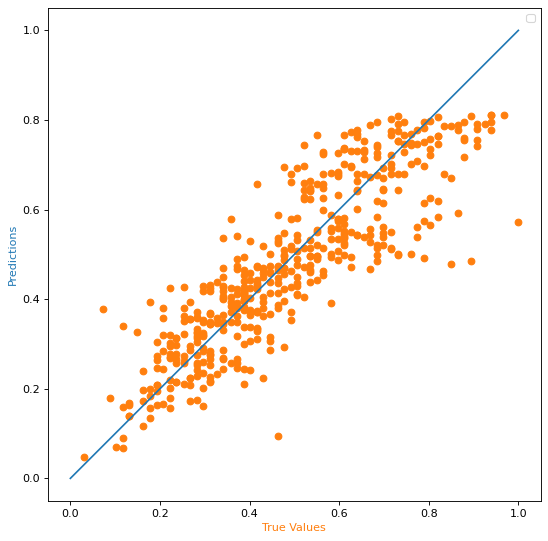

In [19]:
plt.figure(figsize=(10, 8), dpi=80)

a = plt.axes(aspect='equal')

plt.scatter(y_test, prediction, color='C1')
plt.xlabel('True Values',  color='C1')
plt.ylabel('Predictions', color='C0')
plt.legend()
lims = [0, 1]
# plt.xlim(lims)
# plt.ylim(lims)

_ = plt.plot(lims, lims)
